
# PCA Mini-Project 
### Faces recognition example using eigenfaces and SVMs
Our discussion of PCA spent a lot of time on theoretical issues, so in this mini-project we’ll ask you to play around with some sklearn code. The eigenfaces code is interesting and rich enough to serve as the testbed for this entire mini-project.



Note:
The dataset used in this example is a preprocessed excerpt of the
"[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)", aka [LFW_ Download](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (233MB). [Original source](http://scikit-learn.org/0.15/auto_examples/applications/face_recognition.html).

In [1]:

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Loading the dataset

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Split into a training and testing set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Compute PCA

We can now compute a [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction.

In [4]:
n_components = 160

print( "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]) )
t0 = time()

# TODO: Create an instance of PCA, initializing with n_components=n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

#TODO: pass the training dataset (X_train) to pca's 'fit()' method
pca = pca.fit(X_train)


print("done in %0.3fs" % (time() - t0))

Extracting the top 160 eigenfaces from 966 faces
done in 1.060s


Projecting the input data on the eigenfaces orthonormal basis

In [5]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


done in 0.094s


## Train a SVM classification model

Let's fit a [SVM classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to the training set. We'll use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find a good set of parameters for the classifier.

In [6]:

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

/home/felipe/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Evaluation of the model quality on the test set

#### 1. Classification Report
Now that we have the classifier trained, let's run it on the test dataset and qualitatively evaluate its results. Sklearn's [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) shows some of the main classification metrics for each class.

In [7]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.45      0.69      0.55        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.76      0.70      0.73        27
    George W Bush       0.90      0.88      0.89       146
Gerhard Schroeder       0.81      0.88      0.85        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.90      0.78      0.84        36

        micro avg       0.83      0.83      0.83       322
        macro avg       0.77      0.76      0.76       322
     weighted avg       0.84      0.83      0.83       322



#### 2. Confusion Matrix

Another way to look at the performance of the classifier is by looking the [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). We can do that by simply invoking [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

In [8]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   0   2   2   0   0   0]
 [  3  52   0   4   0   1   0]
 [  5   1  19   1   0   0   1]
 [  2   8   2 128   4   1   1]
 [  0   1   0   2  22   0   0]
 [  0   3   0   2   1   8   1]
 [  1   2   2   3   0   0  28]]


#### 3. Plotting The Most Significant Eigenfaces

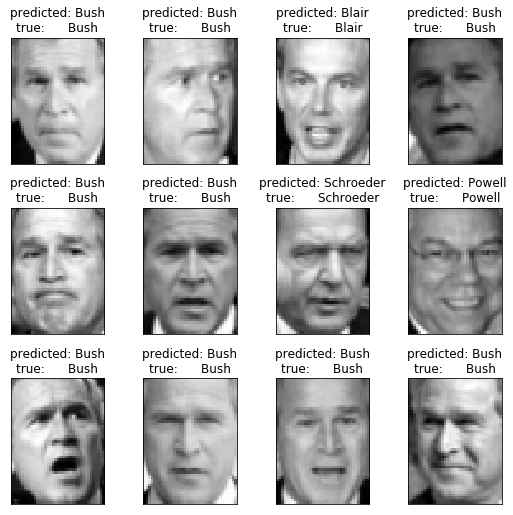

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

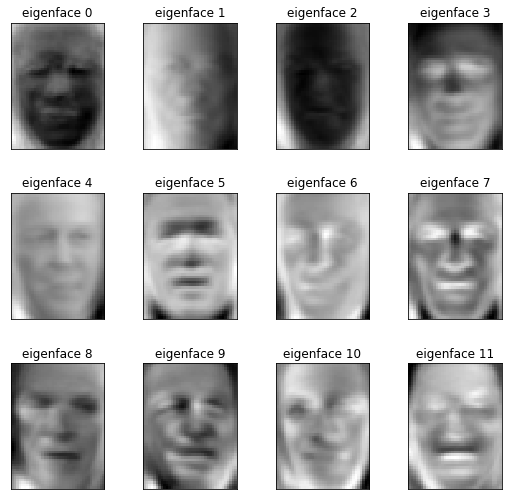

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

## Quiz: Explained Variance Of Each PC

We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. How much of the variance is explained by the first principal component? The second?



In [11]:
pca.explained_variance_ratio_[:80].sum()

0.9094403

## Quiz: How Many PCs To Use?

Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

We’ll learn about the F1 score properly in the lesson on evaluation metrics, but you’ll figure out for yourself whether a good classifier is characterized by a high or low F1 score. You’ll do this by varying the number of principal components and watching how the F1 score changes in response.

As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?

## Quiz: F1 Score Vs. No. Of PCs Used

Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. (For 10 PCs, the plotting functions in the code will break, but you should be able to see the F1 scores.) If you see a higher F1 score, does it mean the classifier is doing better, or worse?

In [12]:
X_train.shape

(966, 1850)

## Quiz: Dimensionality Reduction And Overfitting
Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?

In [13]:
import matplotlib.pyplot as plt

In [14]:
X_cnn = X.reshape(-1,h,w,1)

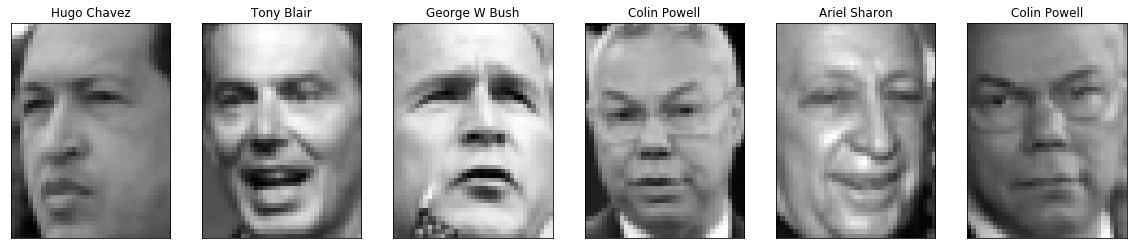

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_cnn[i]), cmap='gray')
    ax.set_title(str(target_names[y[i]]))

In [16]:
from keras.utils import np_utils

# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y[:10])

# one-hot encode the labels
y_cnn = np_utils.to_categorical(y, n_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_cnn[:10])

Using TensorFlow backend.


Integer-valued labels:
[5 6 3 1 0 1 3 4 3 0]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [17]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
standardized_X_cnn = [scaler.fit_transform(np.squeeze(X_cnn)[i]) for i in range(X_cnn.shape[0])]
standardized_X_cnn = np.expand_dims(standardized_X_cnn,axis=-1)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(standardized_X_cnn, y_cnn, test_size=0.25, random_state=42)

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(h, w, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 37, 32)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 9, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 9, 128)        32896     
_________________________________________________________________
max_pooling2d_3 (MaxP

In [21]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [22]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf6', verbose=1, 
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=42, epochs=20,
          validation_split = 0.2, callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 772 samples, validate on 194 samples
Epoch 1/20
 - 4s - loss: 2.0051 - acc: 0.3640 - val_loss: 1.6357 - val_acc: 0.4124

Epoch 00001: val_loss improved from inf to 1.63568, saving model to model.weights.best.hdf6
Epoch 2/20
 - 2s - loss: 1.4619 - acc: 0.4806 - val_loss: 1.1846 - val_acc: 0.5464

Epoch 00002: val_loss improved from 1.63568 to 1.18460, saving model to model.weights.best.hdf6
Epoch 3/20
 - 2s - loss: 1.1237 - acc: 0.6101 - val_loss: 1.0475 - val_acc: 0.6392

Epoch 00003: val_loss improved from 1.18460 to 1.04745, saving model to model.weights.best.hdf6
Epoch 4/20
 - 2s - loss: 0.8325 - acc: 0.7254 - val_loss: 1.0532 - val_acc: 0.6134

Epoch 00004: val_loss did not improve from 1.04745
Epoch 5/20
 - 2s - loss: 0.6584 - acc: 0.7668 - val_loss: 0.9892 - val_acc: 0.5928

Epoch 00005: val_loss improved from 1.04745 to 0.98923, saving model to model.weights.best.hdf6
Epoch 6/20
 - 3s - loss: 0.5210 - acc: 0.8251 - val_los

In [23]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf6')

In [24]:
# evaluate and print test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9099378881987578


In [25]:
# get predictions on the test set
y_hat = model.predict(X_test)

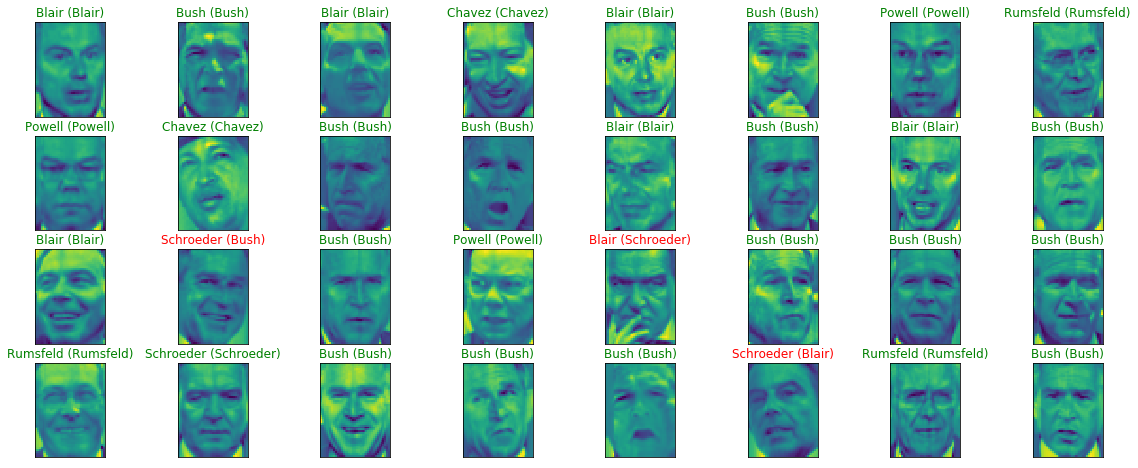

In [26]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    tan = 10
    ax.set_title("{} ({})".format(target_names[pred_idx].split()[-1], target_names[true_idx].split()[-1]),
                 color=("green" if pred_idx == true_idx else "red"))

In [27]:
pred_idx = np.argmax(y_hat, axis=1)
true_idx = np.argmax(y_test, axis=1)


In [28]:
print(confusion_matrix(true_idx, pred_idx, labels=range(n_classes)))

[[ 10   0   3   0   0   0   0]
 [  1  54   0   4   1   0   0]
 [  1   0  19   6   1   0   0]
 [  0   0   0 143   3   0   0]
 [  0   0   0   1  22   0   2]
 [  0   2   0   0   0  13   0]
 [  0   0   1   1   1   1  32]]


In [29]:
print(classification_report(true_idx, pred_idx, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.77      0.80        13
     Colin Powell       0.96      0.90      0.93        60
  Donald Rumsfeld       0.83      0.70      0.76        27
    George W Bush       0.92      0.98      0.95       146
Gerhard Schroeder       0.79      0.88      0.83        25
      Hugo Chavez       0.93      0.87      0.90        15
       Tony Blair       0.94      0.89      0.91        36

        micro avg       0.91      0.91      0.91       322
        macro avg       0.89      0.86      0.87       322
     weighted avg       0.91      0.91      0.91       322

